# TRABAJO PRÁCTICO 1: Análisis Exploratorio de Datos

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

plt.style.use('default')
plt.rcParams['figure.figsize'] = (6, 10)
sns.set(style="darkgrid")
%matplotlib inline

my_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':"1GKPasgRV2WrBkN2AaeKtvUI01BqvE7MA"})
downloaded.GetContentFile('train.csv')

downloaded = drive.CreateFile({'id':"1adIQXiZazufU25CVBYC3K_yTUl9YNpTg"})
downloaded.GetContentFile('test.csv')

downloaded = drive.CreateFile({'id':"1TmlwXmYSN4Yed0K1Gwtp8SLOYe_GlxuN"})
downloaded.GetContentFile('sample_submissions.csv')


In [0]:
train_df = pd.read_csv('train.csv', encoding='latin-1',dtype={'id': np.uint16,'target': np.bool})

In [0]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,True
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,True
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,True
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",True
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,True


## Tratamiento de datos

In [0]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   uint16
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   bool  
dtypes: bool(1), object(3), uint16(1)
memory usage: 200.9+ KB


Podemos observar que las columnas <b><i>"keyword"</i></b> y <b><i>"location"</i></b> poseen algunos valores nulos, vamos a ver si podemos realizar algun tratamiento en particular.

In [0]:
train_df['keyword'].describe()

count           7552
unique           221
top       fatalities
freq              45
Name: keyword, dtype: object

In [0]:
train_df['keyword'].fillna(value='',inplace=True)

In [0]:
train_df['keyword'] = train_df['keyword'].str.replace('%20',' ')

Posiblemente luego analicemos los textos y veamos la posibilidad de completar estos keyword vacios con algun valor mas significativo

In [0]:
train_df['location'].describe()

count     5080
unique    3341
top        USA
freq       104
Name: location, dtype: object

In [0]:
train_df['location'].sample(30)

1954    Republic of the Philippines
5854                       Lima, OH
3080                           Mass
1947                          Miami
108        Instagram - @heyimginog 
2523                     on twitter
5956                            NaN
7420                            USA
1574                      BestCoast
6404                            NaN
2965                            NaN
7046                           SWMO
2552                  Wilbraham, MA
5964      Wakefield, West Yorkshire
2471              Minneapolis,MN,US
1187                            NaN
1418               Insula Barataria
2196                      Hong Kong
5666                        Karachi
1060                            NaN
1380                            NaN
1932                  turner fenton
2037                    Lincoln, IL
1494                            NaN
5411                            NaN
3311                            NaN
1240           taken by piper curda
1903                        

Por ahora dejamos en blanco estos datos, se observa que la ubicacion ingresada no es siempre algo coherente.

## Primeros analisis

In [0]:
train_df['word_count'] = train_df['text'].str.count(' ') + 1
train_df['not_target'] = 0
train_df.loc[train_df['target']==0,'not_target'] = 1

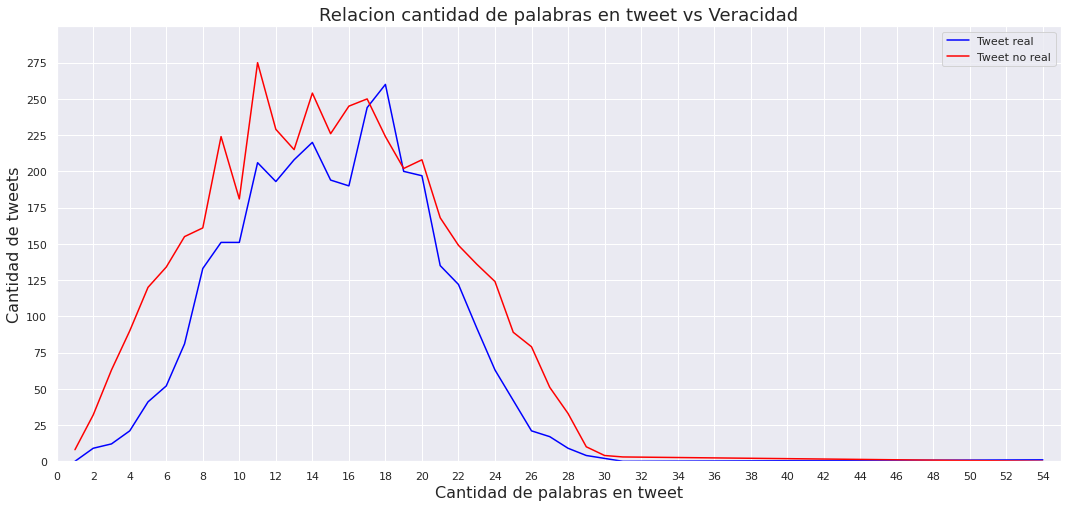

In [0]:
df = train_df.groupby('word_count').agg({'target':'sum','not_target':'sum'}).reset_index()

plt.figure(figsize=(18,8))
ax = sns.lineplot(x='word_count',y='target',data=df,color="blue", label='Tweet real')
ax = sns.lineplot(x='word_count',y='not_target',data=df,color="red", label='Tweet no real')
ax.set_ylim(0,300)
ax.set_yticks(range(0,300,25))
ax.set_xlim(0,55)
ax.set_xticks(range(0,55,2))

ax.set_title('Relacion cantidad de palabras en tweet vs Veracidad', fontsize=18)
ax.set_xlabel('Cantidad de palabras en tweet',fontsize=16)
ax.set_ylabel('Cantidad de tweets', fontsize=16);

## Análisis de la longitud de los tweets

In [0]:
#Creamos una columna con la longitud del tweet.
train_df['longitud_del_tweet'] = train_df['text'].str.len()

In [0]:
#Analizamos las estadísticas de los tweets verdaderos.
train_df[train_df['target']]['longitud_del_tweet'].describe()

count    3271.000000
mean      108.444207
std        29.511567
min        14.000000
25%        88.000000
50%       115.000000
75%       136.000000
max       161.000000
Name: longitud_del_tweet, dtype: float64

In [0]:
#Analizamos las estadísticas de los tweets falsos.
train_df[~train_df['target']]['longitud_del_tweet'].describe()

count    4342.000000
mean       95.981345
std        36.100118
min         7.000000
25%        68.000000
50%       101.000000
75%       130.000000
max       163.000000
Name: longitud_del_tweet, dtype: float64

In [0]:
train_df = train_df.astype({'longitud_del_tweet':np.uint8})

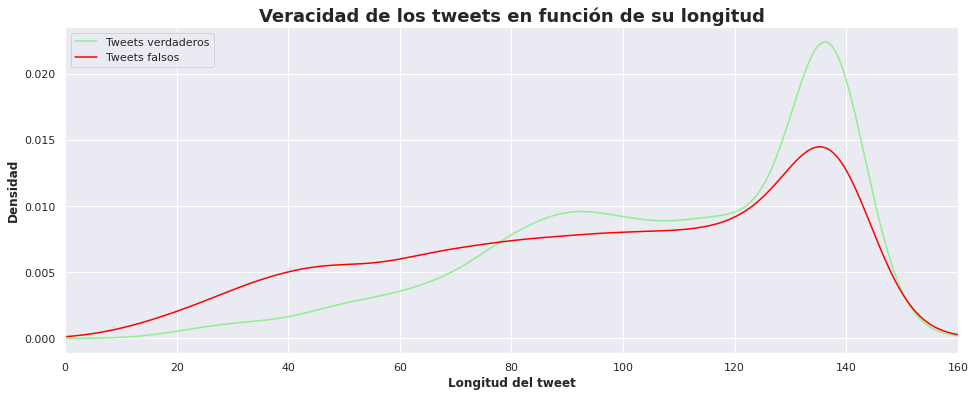

In [0]:
fig= plt.figure()
ax = fig.add_subplot(111)

plt.title('Veracidad de los tweets en función de su longitud',fontsize=18,fontweight='bold')

train_df[train_df['target']]['longitud_del_tweet'].plot.kde(color='lightgreen', figsize=(16, 6), label = 'Tweets verdaderos')
train_df[~train_df['target']]['longitud_del_tweet'].plot.kde(color='red', ax=ax, figsize=(16, 6), label = 'Tweets falsos')

ax.set_xlabel('Longitud del tweet', fontsize=12, fontweight='bold')
ax.set_ylabel('Densidad', fontsize=12, fontweight='bold')

ax.set_xlim(0, 160) #Seteamos los límites del eje x conociendo el valor máximo y mínimo de la longitud de los tweets.
ax.legend()

plt.show()

En está visualización podemos observar que los tweets que tienen una longitud menor a 80 caracteres son en su mayoría falsos, mientras que los que tienen una longitud superior tienden a ser verdaderos. Tambíen podemos ver que la longitud de los tweets tiene un pico llegando a los 140 caracteres, lo cuál tiene sentido considerando las limitaciones que la plataforma solía tener respecto a la longitud de los mismos.

## Análisis de los keywords

Como vimos previamente, la columna keywords tiene **61 registros** con valores nulos. Como es una cantidad pequeña en relación a la cantidad total de registros (**7613 registros**), para este análisis vamos a descartar los registros nulos.

In [0]:
keywords_verdaderos = train_df.loc[~train_df['keyword'].isnull() & train_df['target']]['keyword']
keywords_verdaderos.value_counts()

outbreak       39
wreckage       39
derailment     39
typhoon        37
debris         37
               ..
epicentre       1
body bags       1
blazing         1
electrocute     1
body bag        1
Name: keyword, Length: 220, dtype: int64

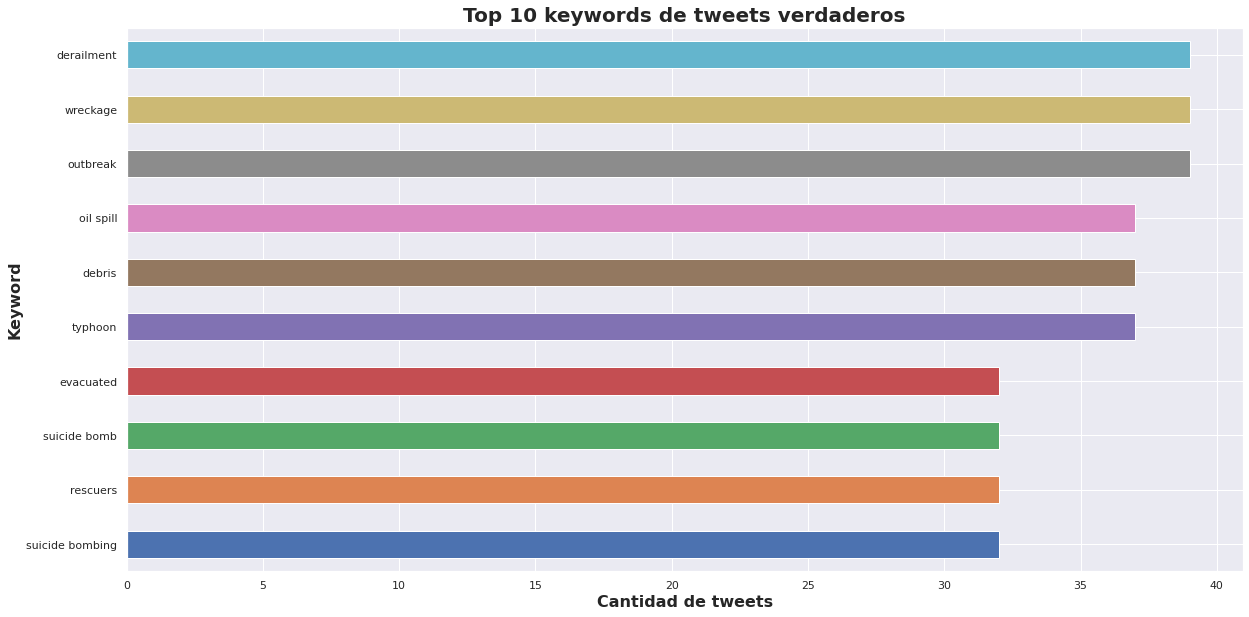

In [0]:
keywords_verdaderos.value_counts().sort_values(ascending=False).head(10).T\
    .sort_values(ascending=True)\
    .plot(figsize=(20,10),kind='barh',rot=0,color=my_colors);

plt.ylabel('Keyword', fontsize=16, fontweight='bold')
plt.title('Top 10 keywords de tweets verdaderos',fontsize=20, fontweight='bold')
plt.xlabel('Cantidad de tweets', fontsize=16, fontweight='bold');

In [0]:
keywords_falsos = train_df.loc[~train_df['keyword'].isnull() & ~train_df['target']]['keyword']
keywords_falsos.value_counts()

body bags          40
armageddon         37
harm               37
deluge             36
wrecked            36
                   ..
typhoon             1
outbreak            1
oil spill           1
suicide bomber      1
suicide bombing     1
Name: keyword, Length: 218, dtype: int64

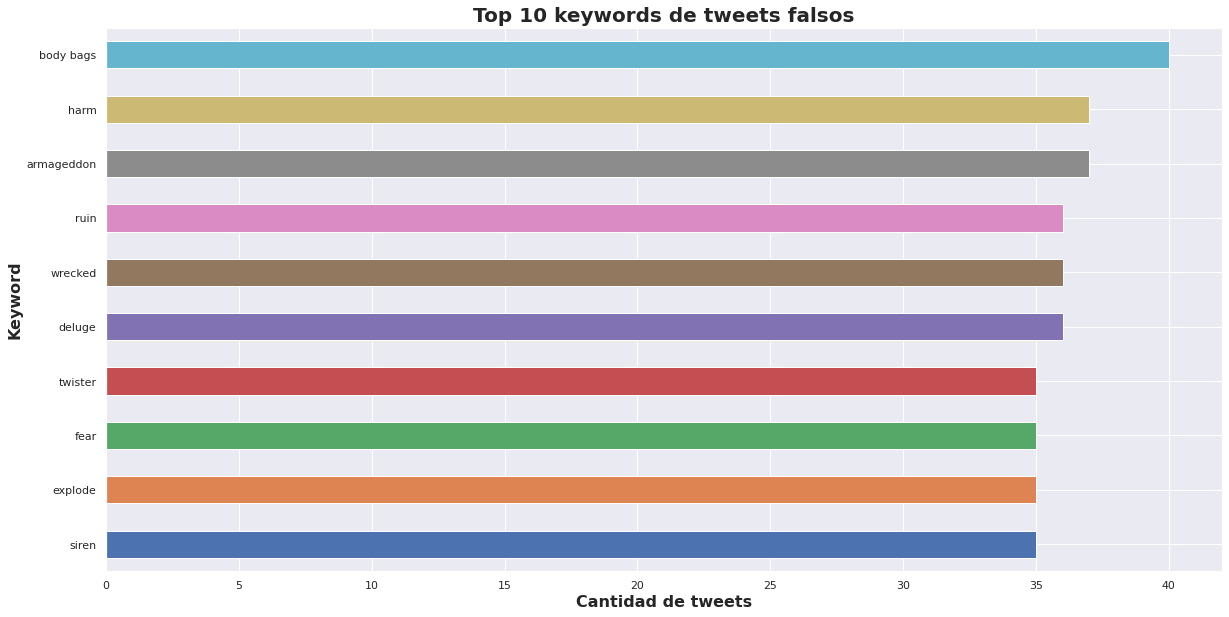

In [0]:
keywords_falsos.value_counts().sort_values(ascending=False).head(10).T\
    .sort_values(ascending=True)\
    .plot(figsize=(20,10),kind='barh',rot=0,color=my_colors);

plt.ylabel('Keyword', fontsize=16, fontweight='bold')
plt.title('Top 10 keywords de tweets falsos',fontsize=20, fontweight='bold')
plt.xlabel('Cantidad de tweets', fontsize=16, fontweight='bold');